# Hands-on Lesson 9 - Q-learning - corrected #
The goal of this hands-on lesson is to implement and play with the Q-learning algorithm.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Q-learning algorithm
The aim of the Q-learning algorithm is to approach the Q-function, also called the action-value function, for the optimal policy $\pi_*$

$$q_{\pi_*}(s,a) = \mathbb{E}_{\pi_*} \left[ G_t | S_t = s, A_t=a \right]$$

where $G_t$ is the return defined as $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots$, with $\gamma$ the discount factor in the interval [0, 1]. 

The Q-algorithm is an off-policy algorithm that learns the Q-function with following iteration 

$$Q(S,A) \leftarrow Q(S,A)  + \alpha \left(R + \gamma \max_{a'}Q(S',a')- Q(S,A) \right)$$

where $\alpha$ is the learning parameter, and $(S,A,R,S')$ is a sequence of state, action, reward, state. 

## The cliff walk problem

The cliff walk problem consists in a grid where a player moves (horizontally or vertically). The initial position is at the bottom left, the final position at the bottom right. All grid points in between are the cliff, the rest is "safe". 

We define an environment class **CliffWalk**, with two main functions:
- **render()** that draws the landscape and the position of the agent
- **step(action)** that returns the new state of the system, the reward and a logical variable determining if the agent is done

In [2]:
class CliffWalk:
        
    def __init__(self, Nhoriz=8, Nvert=4):
        self.Nhoriz = Nhoriz
        self.Nvert = Nvert
        self.Nstates = Nhoriz * Nvert
        self.Nactions = 4
        self.player = None
        self._create_grid() 
        print(self.grid)
        self.render()
        
    def _state(self):
        ''' Maps a position in x,y coordinates to a unique state scalar '''
        return self.player[0] * self.Nhoriz + self.player[1]

    def _create_grid(self):
        self.grid = - 1 * np.ones((self.Nvert, self.Nhoriz), dtype=int)
        self.grid[-1,-1] = 0
        self.grid[-1,1:-1] = -10
        
    def render(self):
        fig, ax = plt.subplots(num=1)
        im = ax.imshow(self.grid)
        ax.set_xticks(np.arange(self.Nhoriz))
        ax.set_yticks(np.arange(self.Nvert))
        if self.player is not None:
            ax.plot(self.player[1], self.player[0] ,'.r')
        plt.show()

    def reset(self):
        self.player = (self.Nvert-1,0)
        return self._state()
    
    def step(self, action):
        # Possible actions
        if action == 0 and self.player[0] > 0: # UP
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < self.Nvert-1: # DOWN
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < self.Nhoriz-1: # RIGHT
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:  # LEFT
            self.player = (self.player[0], self.player[1] - 1)
            
        # Reward
        reward = self.grid[self.player]
        if reward == -1:
            done = False
        else:
            done = True
            
        return self._state(), reward, done

First, familiarize yourself with the environment

[[ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1 -10 -10 -10 -10 -10 -10   0]]


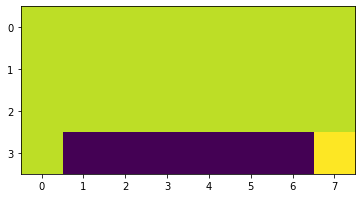

In [3]:
env = CliffWalk()

Now let's add an agent

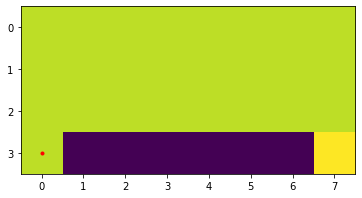

In [4]:
state = env.reset()
env.render()

And let's make it move randomly.

24 3 -1 24 False


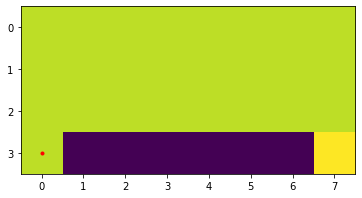

24 2 -10 25 True


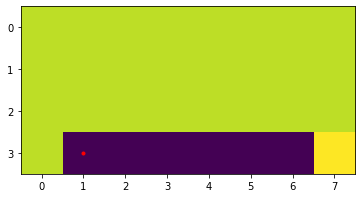

25 0 -1 17 False


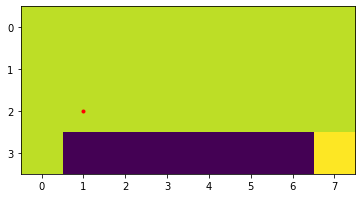

17 1 -10 25 True


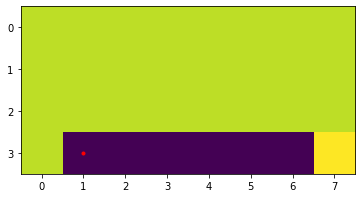

25 1 -10 25 True


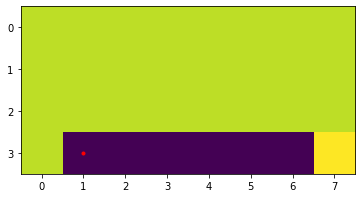

25 1 -10 25 True


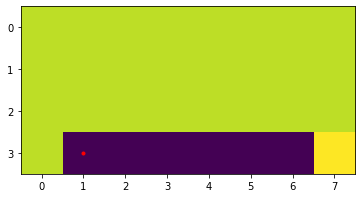

25 0 -1 17 False


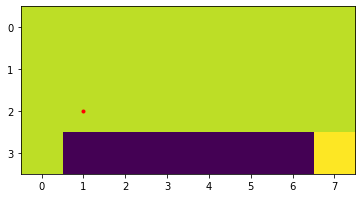

17 0 -1 9 False


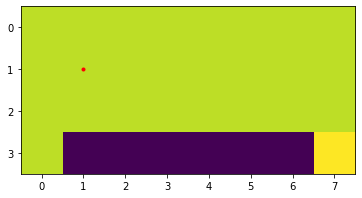

9 0 -1 1 False


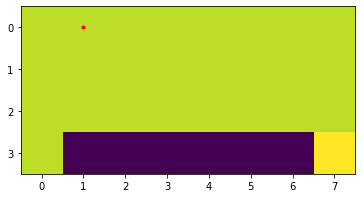

1 1 -1 9 False


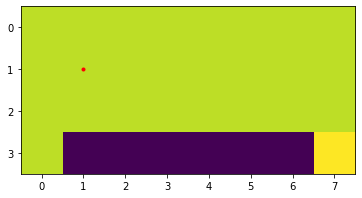

In [5]:
env.reset()
for _ in range(10):
    action = np.random.randint(env.Nactions)
    next_state, reward, done = env.step(action)
    print(state, action, reward, next_state, done)
    state = next_state
    env.render()

## Q_learning

Let's implement the Q-learning algorithm. 

An important aspect is to choose how the policy will explore the state space. Below, we implement an $e$-greedy policy: with probability $e$, a random action is chosen; with probability $(1-e)$, the optimal action is chosen (the one that maximizes $Q(s,a)$ over all possible actions $a$). 

[[ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1 -10 -10 -10 -10 -10 -10   0]]


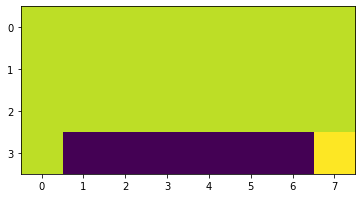

[[-4.9367427  -4.9994825  -4.9325592  -4.93631917]
 [-4.73121079 -4.75948993 -4.72455803 -4.71548412]
 [-4.40347276 -4.38098781 -4.38388427 -4.42020474]
 [-4.00538749 -3.96985496 -3.97327951 -4.01027598]
 [-3.49566079 -3.53635965 -3.4807932  -3.48904565]
 [-2.96154347 -2.92793717 -2.94535167 -2.99852551]
 [-2.36516926 -2.37267308 -2.38314205 -2.36818163]
 [-1.82093062 -1.79966649 -1.82093062 -1.87494083]
 [-5.1645927  -5.23370266 -5.14564457 -5.18558473]
 [-4.88876882 -4.903689   -4.89282583 -4.88093092]
 [-4.50042107 -4.48940441 -4.49304636 -4.69657432]
 [-3.9899799  -3.99479395 -3.99024967 -4.24963092]
 [-3.39324239 -3.39325465 -3.39431241 -3.51186318]
 [-2.68854021 -2.69028028 -2.68847301 -2.76588844]
 [-1.93819382 -1.89416291 -1.89416882 -2.16677622]
 [-1.27429276 -0.99995952 -1.04661746 -1.3465678 ]
 [-5.49331047 -6.0798107  -5.217031   -5.65274626]
 [-5.17807896 -9.74968445 -4.68559    -5.55061158]
 [-4.83860708 -9.0152291  -4.0951     -5.0362198 ]
 [-4.42624232 -9.28210201 -3.43

In [6]:
# LEARNING PARAMETERS
Nepisodes = 1000
exploration_rate = 0.1  # e
learning_rate = 0.1     # alpha
discount_factor = 0.9   # gamma 
   
# INITIALISATION    
env = CliffWalk()
q_values = np.zeros((env.Nstates, env.Nactions))

# Loop for episodes
for _ in range(Nepisodes):
    state = env.reset()    
    done = False
    
    # Loop for steps within an episode
    while not done:            
        # Choose action (e-greedy policy)  
        if np.random.random() > exploration_rate:
            action = np.argmax(q_values[state])
        else:
            action = np.random.choice(env.Nactions)
        # Do the action
        next_state, reward, done = env.step(action)
        # Update q_values       
        target = reward + discount_factor * np.max(q_values[next_state])
        error = target - q_values[state][action]
        q_values[state][action] += learning_rate * error
        # Update state
        state = next_state

print(q_values)

Once the Q-function is learned, we can observe the optimal policy

SARS: 24 0 -1 16


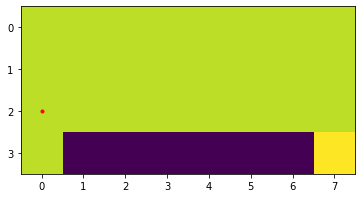

SARS: 16 2 -1 17


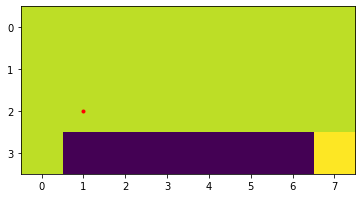

SARS: 17 2 -1 18


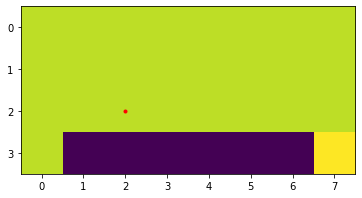

SARS: 18 2 -1 19


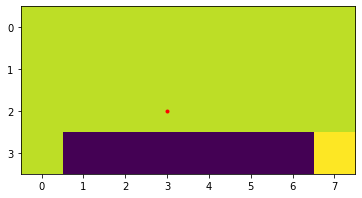

SARS: 19 2 -1 20


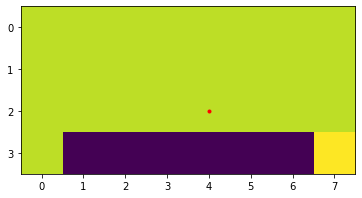

SARS: 20 2 -1 21


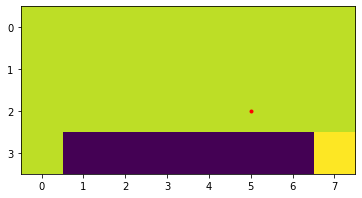

SARS: 21 2 -1 22


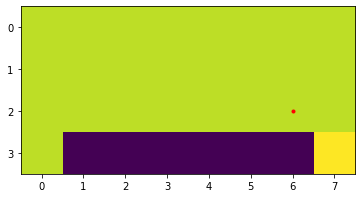

SARS: 22 2 -1 23


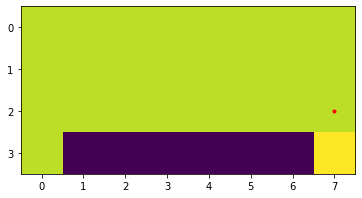

SARS: 23 1 0 31


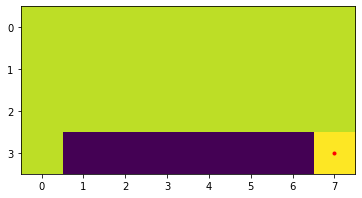

In [7]:
max_steps = 15
state = env.reset()    
done = False
t = 0

# Loop for steps within an episode
while (not done) & (t < max_steps):
    t += 1
    # Choose action (greedy policy)  
    action = np.argmax(q_values[state])
    # Do the action
    next_state, reward, done = env.step(action)
    print('SARS:', state, action, reward, next_state)
    # Update state
    state = next_state
    # plot
    env.render()

**EXERCISE:** To assess the quality of control, we want to plot the return for each episode as the algorithm advances. 

[[ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1 -10 -10 -10 -10 -10 -10   0]]


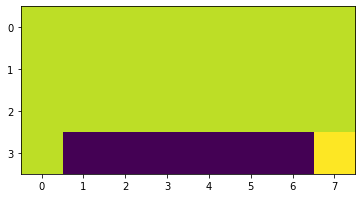

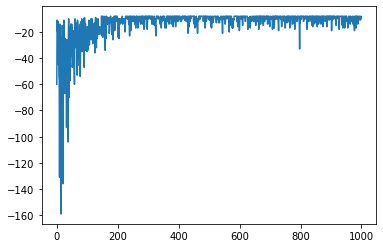

In [8]:
# LEARNING PARAMETERS
Nepisodes = 1000
exploration_rate = 0.1  # e
learning_rate = 0.1     # alpha
discount_factor = 0.9   # gamma 
   
# INITIALISATION    
env = CliffWalk()
q_values = np.zeros((env.Nstates, env.Nactions))
returns = np.zeros(Nepisodes)

# Loop for episodes
for nepisode in range(Nepisodes):
    state = env.reset()    
    done = False
    reward_sum = 0
    
    # Loop for steps within an episode
    while not done:            
        # Choose action (e-greedy policy)  
        if np.random.random() > exploration_rate:
            action = np.argmax(q_values[state])
        else:
            action = np.random.choice(env.Nactions)
        # Do the action
        next_state, reward, done = env.step(action)
        reward_sum += reward
        # Update q_values       
        target = reward + discount_factor * np.max(q_values[next_state])
        error = target - q_values[state][action]
        q_values[state][action] += learning_rate * error
        # Update state
        state = next_state

    returns[nepisode] = reward_sum

plt.plot(returns)

**EXERCISE:** We now want to explore alternative policies. One of them is a Boltzmann exploration (or soft-max): the action is chosen with a probability

$$p(a;s) = \frac{\exp(Q(s,a)/\tau)}{\sum_{a'}\exp(Q(s,a')/\tau) } $$

where $\tau$ is a "temperature". 

Indentify the role of $\tau$ in terms of exploration-exploitation. Implement this policy and compare its performance with an e-greedy policy.

[[ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1 -10 -10 -10 -10 -10 -10   0]]


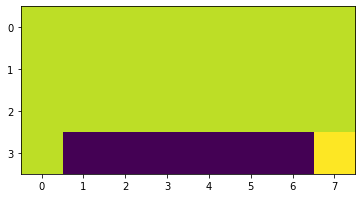

[[-4.72915624 -4.76993535 -4.73040254 -4.73066704]
 [-4.46242541 -4.49695163 -4.48250047 -4.48417074]
 [-4.17891455 -4.20246477 -4.13851832 -4.13690196]
 [-3.75121201 -3.73115163 -3.71910007 -3.77376843]
 [-3.29867752 -3.25644209 -3.26307542 -3.30803665]
 [-2.73741776 -2.7646432  -2.74504437 -2.77457752]
 [-2.21375215 -2.20588771 -2.2216815  -2.23706848]
 [-1.73621787 -1.70872563 -1.73529253 -1.74615988]
 [-4.95799265 -4.99022207 -4.933595   -4.98363139]
 [-4.60033912 -4.57053466 -4.60181016 -4.62149113]
 [-4.20375512 -4.21045255 -4.16555046 -4.26767083]
 [-3.6897631  -3.7132345  -3.66293357 -3.74290494]
 [-3.19104243 -3.10437313 -3.10258682 -3.14985772]
 [-2.52952523 -2.51472376 -2.48099624 -2.50086797]
 [-1.83740814 -1.79008132 -1.78570418 -1.90048672]
 [-1.11449401 -0.99293035 -1.04621628 -1.01736251]
 [-5.29748106 -5.34709795 -5.217031   -5.30315589]
 [-4.77841221 -5.217031   -4.68559    -4.83465901]
 [-4.18924297 -4.68559    -4.0951     -4.23505636]
 [-3.58036057 -4.0951     -3.43

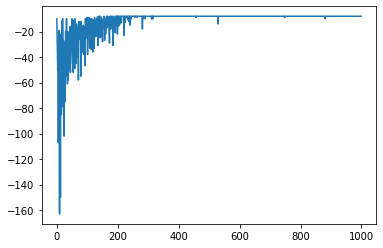

In [9]:
# LEARNING PARAMETERS
Nepisodes = 1000
temperature = 0.01  # temperature
learning_rate = 0.1     # alpha
discount_factor = 0.9   # gamma 
   
# INITIALISATION    
env = CliffWalk()
q_values = np.zeros((env.Nstates, env.Nactions))
returns = np.zeros(Nepisodes)

# Loop for episodes
for nepisode in range(Nepisodes):
    state = env.reset()    
    done = False
    reward_sum = 0
    
    # Loop for steps within an episode
    while not done:            
        # Choose action (soft-max)
        probability = np.exp(q_values[state] / temperature)
        probability /= np.sum(probability)
        action = np.random.choice(env.Nactions, p=probability)           
        # Do the action
        next_state, reward, done = env.step(action)
        reward_sum += reward
        # Update q_values       
        target = reward + discount_factor * np.max(q_values[next_state])
        error = target - q_values[state][action]
        q_values[state][action] += learning_rate * error
        # Update state
        state = next_state

    returns[nepisode] = reward_sum

plt.plot(returns)
print(q_values)

**EXERCISE:** Usually the control is moved toward more exploitation / less exploration as time advances. This is done by changing the exploration rate (the $e$ in the $e$-greedy policy) or the temperature (for the Boltzmann policy) over time. Show that this helps to converge towards the optimal policy.

[[ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1 -10 -10 -10 -10 -10 -10   0]]


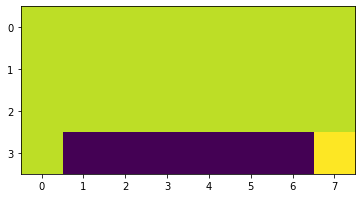

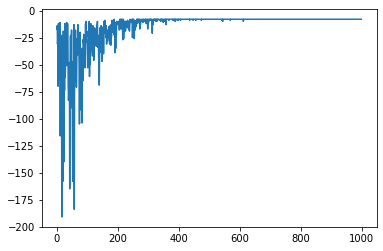

In [10]:
# LEARNING PARAMETERS
Nepisodes = 1000
temperature = 1.        # temperature     <--------- Initial temperature
learning_rate = 0.1     # alpha
discount_factor = 0.9   # gamma 
   
# INITIALISATION    
env = CliffWalk()
q_values = np.zeros((env.Nstates, env.Nactions))
returns = np.zeros(Nepisodes)

# Loop for episodes
for nepisode in range(Nepisodes):
    state = env.reset()    
    done = False
    reward_sum = 0
    temperature *= 0.9954  # <-------- After 1000 episodes, the temperature will be 0.99954**1000 = 0.01
    
    # Loop for steps within an episode
    while not done:            
        # Choose action (soft-max)
        probability = np.exp(q_values[state] / temperature)
        probability /= np.sum(probability)
        action = np.random.choice(env.Nactions, p=probability)           
        # Do the action
        next_state, reward, done = env.step(action)
        reward_sum += reward
        # Update q_values       
        target = reward + discount_factor * np.max(q_values[next_state])
        error = target - q_values[state][action]
        q_values[state][action] += learning_rate * error
        # Update state
        state = next_state

    returns[nepisode] = reward_sum

plt.plot(returns)

## Adding some stochasticity 

Now the environment is no longer deterministic. We imagine there are wind gusts towards the cliff, and with a certain probability, the agent may be moved downwards instead of the chosen action

In [12]:
class CliffWalkStochastic:      
    def __init__(self, Nhoriz=8, Nvert=4, Pwind=0.3):
        self.Pwind = Pwind  # New line
        self.Nhoriz = Nhoriz
        self.Nvert = Nvert
        self.Nstates = Nhoriz * Nvert
        self.Nactions = 4
        self.player = None
        self._create_grid() 
        print(self.grid)
        self.render()
        
    def _state(self):
        ''' Maps a position in x,y coordinates to a unique state scalar '''
        return self.player[0] * self.Nhoriz + self.player[1]

    def _create_grid(self):
        self.grid = - 1 * np.ones((self.Nvert, self.Nhoriz), dtype=int)
        self.grid[-1,-1] = 0
        self.grid[-1,1:-1] = -10
        
    def render(self):
        fig, ax = plt.subplots(num=1)
        im = ax.imshow(self.grid)
        ax.set_xticks(np.arange(self.Nhoriz))
        ax.set_yticks(np.arange(self.Nvert))
        if self.player is not None:
            ax.plot(self.player[1], self.player[0] ,'.r')
        plt.show()

    def reset(self):
        self.player = (self.Nvert-1,0)
        return self._state()   

    def step(self, action):
        if np.random.random() < self.Pwind:  # New lines 
            action = 1                       #
        # Possible actions
        if action == 0 and self.player[0] > 0: # UP
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < self.Nvert-1: # DOWN
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < self.Nhoriz-1: # RIGHT
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:  # LEFT
            self.player = (self.player[0], self.player[1] - 1)
            
        # Reward
        reward = self.grid[self.player]
        if reward == -1:
            done = False
        else:
            done = True
            
        return self._state(), reward, done

**EXERCISE:** See how this stochastic wind affects the optimal policy. 

[[ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1 -10 -10 -10 -10 -10 -10   0]]


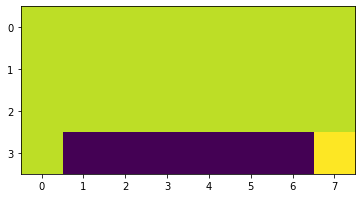

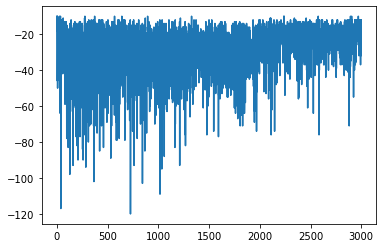

In [13]:
# LEARNING PARAMETERS
Nepisodes = 3000
temperature = 1        # temperature
learning_rate = 0.03     # alpha
discount_factor = 0.9   # gamma 
   
# INITIALISATION    
env = CliffWalkStochastic()
q_values = np.zeros((env.Nstates, env.Nactions))
returns = np.zeros(Nepisodes)

# Loop for episodes
for nepisode in range(Nepisodes):
    state = env.reset()    
    done = False
    reward_sum = 0
    temperature *= 0.999
    
    # Loop for steps within an episode
    while not done:            
        # Choose action (soft-max)
        probability = np.exp(q_values[state] / temperature)
        probability /= np.sum(probability)
        action = np.random.choice(env.Nactions, p=probability)           
        # Do the action
        next_state, reward, done = env.step(action)
        reward_sum += reward
        # Update q_values       
        target = reward + discount_factor * np.max(q_values[next_state])
        error = target - q_values[state][action]
        q_values[state][action] += learning_rate * error
        # Update state
        state = next_state

    returns[nepisode] = reward_sum

plt.plot(returns)

SARS: 24 0 -1 16


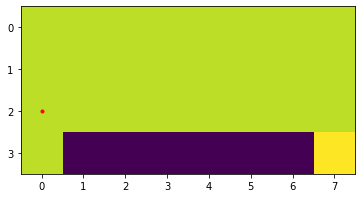

SARS: 16 0 -1 8


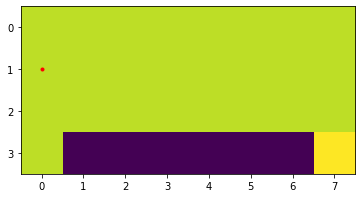

SARS: 8 0 -1 0


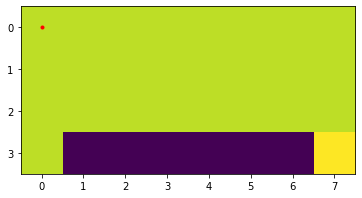

SARS: 0 2 -1 8


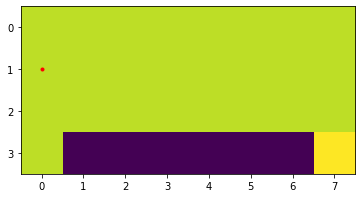

SARS: 8 0 -1 0


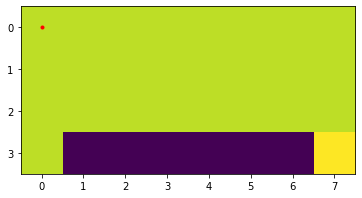

SARS: 0 2 -1 1


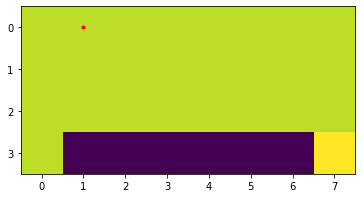

SARS: 1 2 -1 2


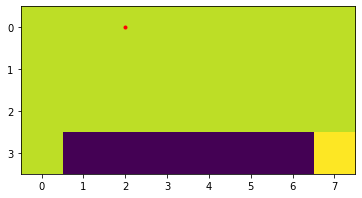

SARS: 2 2 -1 3


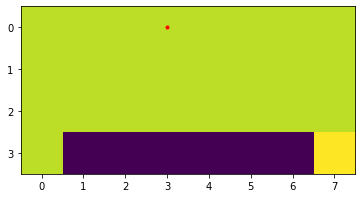

SARS: 3 2 -1 4


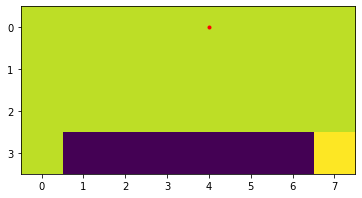

SARS: 4 2 -1 5


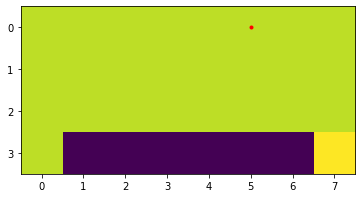

SARS: 5 2 -1 6


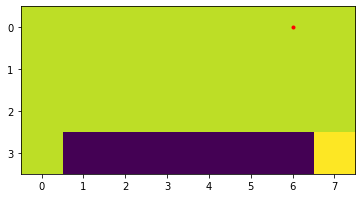

SARS: 6 2 -1 7


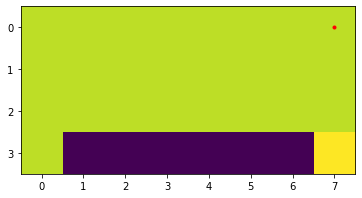

SARS: 7 1 -1 15


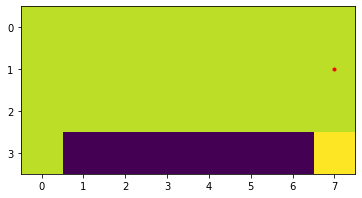

SARS: 15 1 -1 23


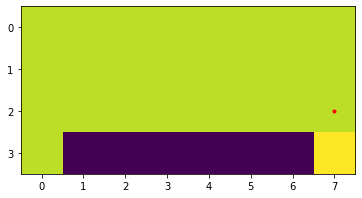

SARS: 23 1 0 31


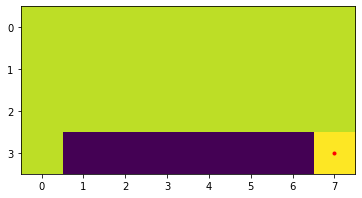

In [14]:
max_steps = 20
state = env.reset()    
done = False
t = 0

# Loop for steps within an episode
while (not done) & (t < max_steps):
    t += 1
    # Choose action (greedy policy)  
    action = np.argmax(q_values[state])
    # Do the action
    next_state, reward, done = env.step(action)
    print('SARS:', state, action, reward, next_state)
    # Update state
    state = next_state
    # plot
    env.render()